In [116]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import logging
import sys
log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG,
                    format='%(asctime)s.%(msecs)03d [%(levelname)s] %(message)s',
                    datefmt='%H:%M:%S')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
with open('/Users/palmerio/Science_projects/GRB_population_model/init/parameters.yml', 'r') as f:
        params = yaml.safe_load(f)
def BPL_lum(logL, logLbreak, slopeL, slopeH):
    """
        Returns the unnormalized broken power law function
        Expects Lum arguments to be in log scale
    """
    x = 10.**(logL - logLbreak)
    BPL_func = np.where(x <= 1, x**(1.-slopeL), x**(1.-slopeH))
    return BPL_func
def Schechter_log(self, logL, logLbreak, slope):
    """
        Returns the unnormalized Schechter function
        Expects Lum arguments to be in log scale
    """
    x = 10.**(logL - logLbreak)
    Sch = x**(1.-slope) * np.exp(-x)
    return Sch

In [112]:
class Distribution:
    def __init__(self, name, func=None, func_args={}, lim_min=None, lim_max=None, filename=None):
        if not isinstance(name, str):
            raise TypeError('The name of your Distribution must be a string.')
        self.func = func
        self.func_args = self._check_args(func, func_args)
        self.lim_min = lim_min
        self.lim_max = lim_max
        
    def plot(self, xrange=None, ax=None):
        if ax is None:
            ax = plt.gca()
        if xrange is None:
            xrange = np.linspace(lim_min, lim_max, 100)
        ax.plot(xrange, self.func(xrange, **self.func_args))

    def _check_args(self, func, args):
        import inspect
        req_args = inspect.signature(func).parameters.keys()
        ign_args = {k:args[k] for k in args if k not in req_args}
        clean_args = args.copy()
        if ign_args:
            log.warning("These provided arguments will be ignored because they "
                        "are not used by the provided function: {}".format(ign_args))
            for k in ign_args.keys():
                clean_args.pop(k)
        return clean_args

In [117]:
a = Distribution(name='ES', func=Schechter_log, func_args=params['luminosity_function'])

16:19:57.228 [WARNING] These provided arguments will be ignored because they are not used by the provided function: {'model': 'ES', 'logLmin': 49.6989700043, 'logLmax': 53.0, 'k_evol': 1.0}


TypeError: Schechter_log() missing 1 required positional argument: 'logL'

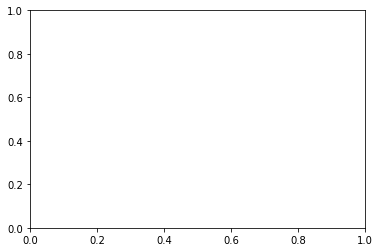

In [118]:
a.plot(xrange=np.linspace(50, 55))

In [119]:
testdict={'logL':3,
           'logLbreak':1,
         'slopeL':-2,
         'zololo':'pi'}

def _check_args(func, args):
    import inspect
    req_args = inspect.signature(func).parameters.keys()
    ign_args = {k:args[k] for k in args if k not in req_args}
    clean_args = args.copy()
    if ign_args:
        log.warning("These provided arguments will be ignored because they "
                    "are not used by the provided function: {}".format(ign_args))
        for k in ign_args.keys():
            clean_args.pop(k)
    return clean_args


In [102]:
x = _check_args(BPL_lum, testdict)

16:13:51.060 [WARNING] These provided arguments will be ignored because theyare not used by the provided function: {'zololo': 'pi'}


In [122]:
np.where(3<4, 2, 1)

array(2)

In [129]:


def create_Stern_hist_for_lnL(fname=None, verbose=False):
    """
        Create the histogram from [Stern et al. 2001]
        (https://ui.adsabs.harvard.edu/abs/2001ApJ...563...80S/abstract)
        Fig. 23 rebinned to avoid low counts
        The logN-logP is converted to number count histogram for
        comparison with the likelihood function
    """
    global T_live_BATSE, T_BATSE_mission
    if fname is None:
        fname = '../observational_constraints/Stern.txt'

    bins = read_column(fname, 0, array=False)
    hist = read_column(fname, 1)
    err = read_column(fname, 2)
    bins.append(50.0)  # append right edge of last bin
    bins = np.array(bins)

    # Uncorrect for delta_bin, time and fraction of sky observed
    delta_bin = np.log10(bins[1:]/bins[:-1])
    hist, err, _u = log_to_lin(hist, err)
    hist *= delta_bin * T_BATSE_mission * Omega_BATSE/(4*np.pi)
    err *= delta_bin * T_BATSE_mission * Omega_BATSE/(4*np.pi)

    if verbose:
        ln_oi = 0.
        for i, val in enumerate(hist):
            val2 = 10**val
            delta_bin = np.log10(bins[i+1]/bins[i])
            val2 *= delta_bin * T_live_BATSE
            ln_oi += val2*np.log(val2) - val2
        print(f"ln(o_i!) = {ln_oi} from Stern histogram")

    return bins, hist, err
def read_column(filename, column_nb, end=None, dtype=float, array=True, splitter=None, stripper=None, verbose=False):
    """
    Function used to read ASCII files.
    It will skip lines starting with '#', '!' or '%'.

    Parameters
    ----------
    filename : [str]
        Name of the file containing the data

    column_nb: [int]
        Number of the column for the data.

    end   : [int]
        Number of lines to read. Note: commented lines (i.e. starting with '#', '!', or '%') do not count as lines for this purpose.
        Default is None, which reads the whole file.

    dtype : [data-type]
        Type of the returned data. Default is float.

    array : [boolean]
        If True returns xdata as an array rather than a list. Default is True (arrays are faster)

    splitter : [str]
        String to use as a delimiter between columns. Default is None (uses default for str.split() which is a whitespace)

    stripper : [str]
        String to strip at the end of each line. Default is None (uses default for str.strip() which is a whitespace)

    Returns
    -------
    xdata : [array/list]
        x data
    """

    nan = False

    xdata = []
    i_counter = 0
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            if len(line) != 0:
                if line[0] != '#' and line[0] != '!' and line[0] != '%':
                    i_counter += 1
                    line = line.strip(stripper)
                    columns = line.split(splitter)
                    try:
                        xdata.append(dtype(columns[column_nb]))
                    except ValueError:
                        nan = True
                        xdata.append(np.nan)
                        if verbose:
                            log.error("In read_column for {}: could not convert {} to {}, \
                                       so added NaN.".format(filename, columns[column_nb], dtype))
                    except IndexError:
                        if verbose:
                            log.error("In read_column for {}: no data found for column {:d}, line {:d}. \
                                       Input will be NaN.".format(filename, column_nb, i))
            if (end is not None) and (i_counter >= end):
                break
    if array:
        xdata = np.asarray(xdata, dtype=dtype)
    if nan:
        log.warning("In read_column for {}: some strings could not be converted to {} \
            NaNs were added instead.".format(filename, dtype))

    return xdata

def log_to_lin(log_x, log_x_errp, log_x_errm=None):
    """
        Takes logscale data with errors and converts to linear scale with correct error propagation.
        If log_x_errm is not provided, errors are assumed symmetric.
        Returns : x, x_errp, x_errm
    """
    if log_x_errm is None:
        log_x_errm = log_x_errp
    x = 10**log_x
    x_errp = x * (10**log_x_errp - 1.0)
    x_errm = x * (1.0 - 10**(-log_x_errm))

    return x, x_errp, x_errm

T_live_BATSE = 6.54  # years (Goldstein et al. 2013)
T_BATSE_mission = 9.1  # years (Stern et al. 2001)
Omega_BATSE = 0.7 * 4. * np.pi  # years (Stern et al. 2001)
R_tot_BATSE = 1110.  # LGRBs per year in 4 pi above 0.066825 ph/s/cm2
R_tot_BATSE_err = 40.  # LGRBs per year in 4 pi above 0.066825 ph/s/cm2




In [130]:
bins, hist, err = create_Stern_hist_for_lnL()

In [135]:
outfname = '/Users/palmerio/Science_projects/GRB_population_model/observational_constraints/Stern.txt'
with open(outfname,'w') as f:
    for i in range(len(hist)):
        f.write("{:12.5e} \t{:12.5e} \t{:12.5e}\n".format(bins[i], hist[i], err[i]))

In [148]:
np.sum(hist)

7248.74150961954